## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp020'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 5e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

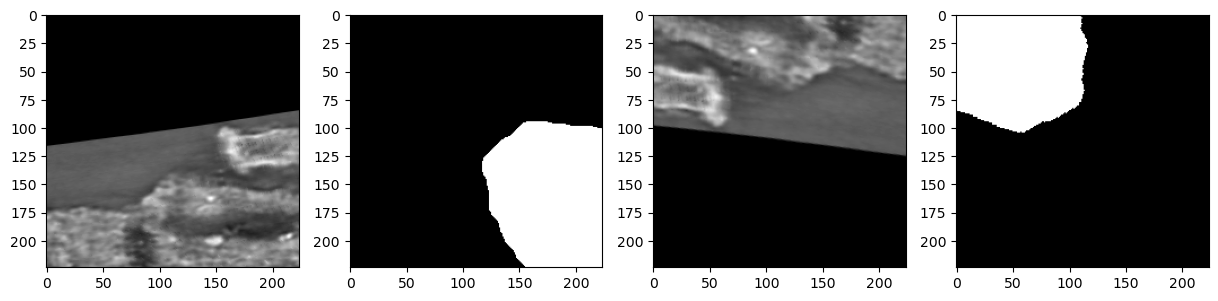

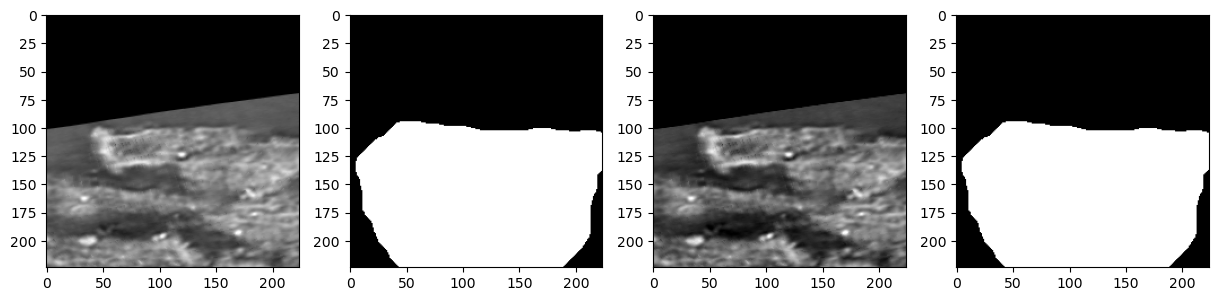

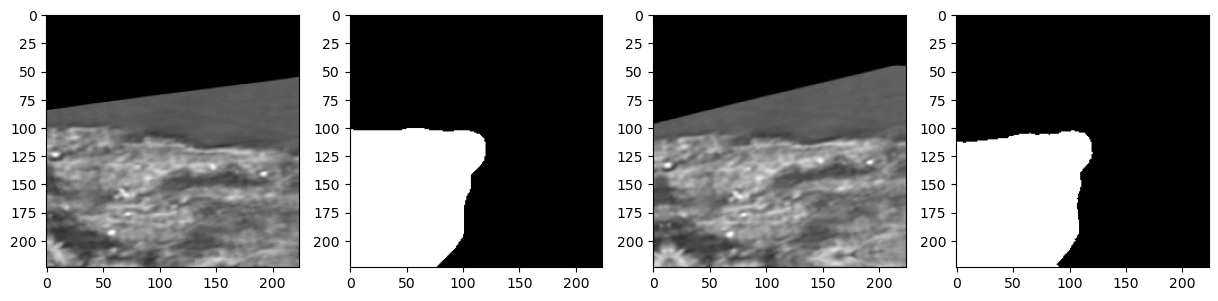

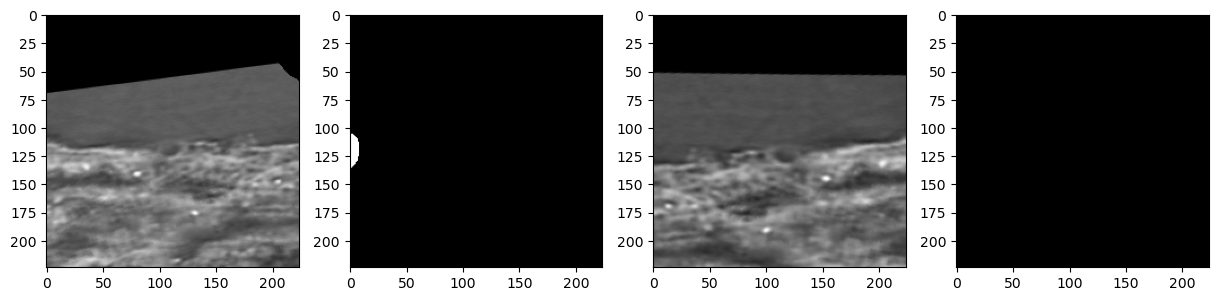

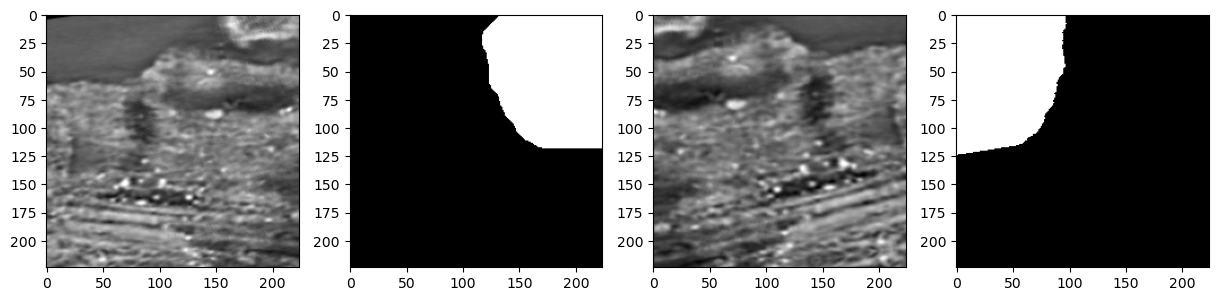

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48115

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.19292939584710372
th: 0.15, fbeta: 0.2223206346656519
th: 0.2, fbeta: 0.3116489722436476
th: 0.25, fbeta: 0.33232491502246797
th: 0.3, fbeta: 0.31788722022165505
th: 0.35, fbeta: 0.28068791425885653
th: 0.4, fbeta: 0.23866950180478008
th: 0.45, fbeta: 0.19538403823522457


best_th: 0.25, fbeta: 0.33232491502246797
Epoch 1 - avg_train_loss: 0.4460  avg_val_loss: 0.3405  time: 118s
Epoch 1 - avgScore: 0.3323
Epoch 1 - Save Best Score: 0.3323 Model
Epoch 1 - Save Best Loss: 0.3405 Model


th: 0.5, fbeta: 0.15636168959427654


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.28096600462440935
th: 0.15, fbeta: 0.3599859753642344
th: 0.2, fbeta: 0.3090259631871985
th: 0.25, fbeta: 0.23494767002372888
th: 0.3, fbeta: 0.16721190503526087
th: 0.35, fbeta: 0.11481296641803101
th: 0.4, fbeta: 0.07636993061001561
th: 0.45, fbeta: 0.046838284086304034


best_th: 0.15, fbeta: 0.3599859753642344
Epoch 2 - avg_train_loss: 0.2543  avg_val_loss: 0.3330  time: 117s
Epoch 2 - avgScore: 0.3600
Epoch 2 - Save Best Score: 0.3600 Model
Epoch 2 - Save Best Loss: 0.3330 Model


th: 0.5, fbeta: 0.027870609406535334


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.2981333008102929
th: 0.15, fbeta: 0.19066413549424327
th: 0.2, fbeta: 0.12081012521117564
th: 0.25, fbeta: 0.08345425322694988
th: 0.3, fbeta: 0.05832003455459078
th: 0.35, fbeta: 0.0397401527933236
th: 0.4, fbeta: 0.026809087862295845
th: 0.45, fbeta: 0.01557185357287208


best_th: 0.1, fbeta: 0.2981333008102929
Epoch 3 - avg_train_loss: 0.2392  avg_val_loss: 0.3673  time: 115s
Epoch 3 - avgScore: 0.2981


th: 0.5, fbeta: 0.005562996164484222


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29443108595954304
th: 0.15, fbeta: 0.20185396521203391
th: 0.2, fbeta: 0.12673567802750124
th: 0.25, fbeta: 0.07410854948056525
th: 0.3, fbeta: 0.04337323550774118
th: 0.35, fbeta: 0.02435393622569735
th: 0.4, fbeta: 0.011909519476874242
th: 0.45, fbeta: 0.005754048908311176


best_th: 0.1, fbeta: 0.29443108595954304
Epoch 4 - avg_train_loss: 0.2164  avg_val_loss: 0.3827  time: 115s
Epoch 4 - avgScore: 0.2944


th: 0.5, fbeta: 0.002542403985715937


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3771812393313938
th: 0.15, fbeta: 0.2736423461925499
th: 0.2, fbeta: 0.17576234594507356
th: 0.25, fbeta: 0.1005352910676538
th: 0.3, fbeta: 0.053122004611569636
th: 0.35, fbeta: 0.02863889927620828
th: 0.4, fbeta: 0.01774309555468003
th: 0.45, fbeta: 0.01162390005612575


best_th: 0.1, fbeta: 0.3771812393313938
Epoch 5 - avg_train_loss: 0.2046  avg_val_loss: 0.4019  time: 114s
Epoch 5 - avgScore: 0.3772
Epoch 5 - Save Best Score: 0.3772 Model
Epoch 5 - Save Best Loss: 0.4019 Model


th: 0.5, fbeta: 0.0065838231145799375


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37076307033703787
th: 0.15, fbeta: 0.3668373338089414
th: 0.2, fbeta: 0.35567762943524034
th: 0.25, fbeta: 0.339571309075077
th: 0.3, fbeta: 0.3172328743018635
th: 0.35, fbeta: 0.2862526195767796
th: 0.4, fbeta: 0.24928230771056356
th: 0.45, fbeta: 0.20938245726053933


best_th: 0.1, fbeta: 0.37076307033703787
Epoch 6 - avg_train_loss: 0.2001  avg_val_loss: 0.3690  time: 115s
Epoch 6 - avgScore: 0.3708


th: 0.5, fbeta: 0.17113390508795148


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3813095250567076
th: 0.15, fbeta: 0.3877639475194675
th: 0.2, fbeta: 0.37548884220527107
th: 0.25, fbeta: 0.3539908222689305
th: 0.3, fbeta: 0.3251368856870728
th: 0.35, fbeta: 0.293932901290086
th: 0.4, fbeta: 0.26064865646197916
th: 0.45, fbeta: 0.22994851938980243


best_th: 0.15, fbeta: 0.3877639475194675
Epoch 7 - avg_train_loss: 0.1956  avg_val_loss: 0.3724  time: 116s
Epoch 7 - avgScore: 0.3878
Epoch 7 - Save Best Score: 0.3878 Model
Epoch 7 - Save Best Loss: 0.3724 Model


th: 0.5, fbeta: 0.19920830421861324


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3931363155796348
th: 0.15, fbeta: 0.4013724554252607
th: 0.2, fbeta: 0.39574942511863337
th: 0.25, fbeta: 0.38132524407413626
th: 0.3, fbeta: 0.3599176444257019
th: 0.35, fbeta: 0.3357454359330255
th: 0.4, fbeta: 0.3062116647689337
th: 0.45, fbeta: 0.2714081088521678


best_th: 0.15, fbeta: 0.4013724554252607
Epoch 8 - avg_train_loss: 0.1927  avg_val_loss: 0.4058  time: 116s
Epoch 8 - avgScore: 0.4014
Epoch 8 - Save Best Score: 0.4014 Model
Epoch 8 - Save Best Loss: 0.4058 Model


th: 0.5, fbeta: 0.23401759475527673


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.362164270470062
th: 0.15, fbeta: 0.38228429325009716
th: 0.2, fbeta: 0.3885675540871905
th: 0.25, fbeta: 0.3756224167892735
th: 0.3, fbeta: 0.3517443885150186
th: 0.35, fbeta: 0.31897617506014003
th: 0.4, fbeta: 0.2802171550862186
th: 0.45, fbeta: 0.24182940420215654


best_th: 0.2, fbeta: 0.3885675540871905
Epoch 9 - avg_train_loss: 0.1871  avg_val_loss: 0.3875  time: 116s
Epoch 9 - avgScore: 0.3886


th: 0.5, fbeta: 0.19831155237730178


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.405870464053742
th: 0.15, fbeta: 0.3938083187690589
th: 0.2, fbeta: 0.37162133962259897
th: 0.25, fbeta: 0.3470660716220188
th: 0.3, fbeta: 0.32133090509582457
th: 0.35, fbeta: 0.2941048553311152
th: 0.4, fbeta: 0.2621081625768765
th: 0.45, fbeta: 0.22871957283393707


best_th: 0.1, fbeta: 0.405870464053742
Epoch 10 - avg_train_loss: 0.1851  avg_val_loss: 0.3718  time: 116s
Epoch 10 - avgScore: 0.4059
Epoch 10 - Save Best Score: 0.4059 Model
Epoch 10 - Save Best Loss: 0.3718 Model


th: 0.5, fbeta: 0.19702742370863807


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4262434779479028
th: 0.15, fbeta: 0.42273643670391275
th: 0.2, fbeta: 0.4046005174885058
th: 0.25, fbeta: 0.37631560429022626
th: 0.3, fbeta: 0.33682490846894014
th: 0.35, fbeta: 0.2944675827025105
th: 0.4, fbeta: 0.25423652921833106
th: 0.45, fbeta: 0.21605231861743573


best_th: 0.1, fbeta: 0.4262434779479028
Epoch 11 - avg_train_loss: 0.1794  avg_val_loss: 0.4095  time: 117s
Epoch 11 - avgScore: 0.4262
Epoch 11 - Save Best Score: 0.4262 Model
Epoch 11 - Save Best Loss: 0.4095 Model


th: 0.5, fbeta: 0.17979213088722032


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41708750585173887
th: 0.15, fbeta: 0.4285170330170298
th: 0.2, fbeta: 0.42878596342881214
th: 0.25, fbeta: 0.4205355067949316
th: 0.3, fbeta: 0.4021875558111225
th: 0.35, fbeta: 0.37544627183091017
th: 0.4, fbeta: 0.34158393124582737
th: 0.45, fbeta: 0.306509801938047


best_th: 0.2, fbeta: 0.42878596342881214
Epoch 12 - avg_train_loss: 0.1737  avg_val_loss: 0.4501  time: 117s
Epoch 12 - avgScore: 0.4288
Epoch 12 - Save Best Score: 0.4288 Model
Epoch 12 - Save Best Loss: 0.4501 Model


th: 0.5, fbeta: 0.26709390588957194


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39639370253283573
th: 0.15, fbeta: 0.4176211120864751
th: 0.2, fbeta: 0.42597645580107857
th: 0.25, fbeta: 0.4221995867966023
th: 0.3, fbeta: 0.41065489070328265
th: 0.35, fbeta: 0.3898383817931177
th: 0.4, fbeta: 0.3646745838283284
th: 0.45, fbeta: 0.3344076382082787


best_th: 0.2, fbeta: 0.42597645580107857
Epoch 13 - avg_train_loss: 0.1677  avg_val_loss: 0.4103  time: 117s
Epoch 13 - avgScore: 0.4260


th: 0.5, fbeta: 0.3000726896040361


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3900521574130379
th: 0.15, fbeta: 0.37727435795150943
th: 0.2, fbeta: 0.34484613555093613
th: 0.25, fbeta: 0.3084846786704974
th: 0.3, fbeta: 0.27217938390420837
th: 0.35, fbeta: 0.23926368927262948
th: 0.4, fbeta: 0.2064312175146752
th: 0.45, fbeta: 0.1738325045560661


best_th: 0.1, fbeta: 0.3900521574130379
Epoch 14 - avg_train_loss: 0.1673  avg_val_loss: 0.5044  time: 115s
Epoch 14 - avgScore: 0.3901


th: 0.5, fbeta: 0.14330424601523598


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3910452406061802
th: 0.15, fbeta: 0.40157176433668185
th: 0.2, fbeta: 0.400772013923532
th: 0.25, fbeta: 0.3968687373059804
th: 0.3, fbeta: 0.3857315698964558
th: 0.35, fbeta: 0.3682233637421789
th: 0.4, fbeta: 0.34454721402037725
th: 0.45, fbeta: 0.3148858781059524


best_th: 0.15, fbeta: 0.40157176433668185
Epoch 15 - avg_train_loss: 0.1633  avg_val_loss: 0.4321  time: 115s
Epoch 15 - avgScore: 0.4016


th: 0.5, fbeta: 0.28203536775571386


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3807302392648622
th: 0.15, fbeta: 0.38507818200271426
th: 0.2, fbeta: 0.38418259035202207
th: 0.25, fbeta: 0.37885864340946357
th: 0.3, fbeta: 0.371052723274322
th: 0.35, fbeta: 0.3596830307189774
th: 0.4, fbeta: 0.3476180236243282
th: 0.45, fbeta: 0.3319800394523306


best_th: 0.15, fbeta: 0.38507818200271426
Epoch 16 - avg_train_loss: 0.1540  avg_val_loss: 0.5153  time: 116s
Epoch 16 - avgScore: 0.3851


th: 0.5, fbeta: 0.31353971643458656


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4127195203844268
th: 0.15, fbeta: 0.4192257751177359
th: 0.2, fbeta: 0.4092940815032963
th: 0.25, fbeta: 0.39075716936879484
th: 0.3, fbeta: 0.3623583013657982
th: 0.35, fbeta: 0.32585871511504894
th: 0.4, fbeta: 0.2920619841378057
th: 0.45, fbeta: 0.25750862279831405


best_th: 0.15, fbeta: 0.4192257751177359
Epoch 17 - avg_train_loss: 0.1533  avg_val_loss: 0.4604  time: 116s
Epoch 17 - avgScore: 0.4192


th: 0.5, fbeta: 0.22286696930045252


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.415336930998549
th: 0.15, fbeta: 0.4166608215966851
th: 0.2, fbeta: 0.4045162520262796
th: 0.25, fbeta: 0.3855954333130661
th: 0.3, fbeta: 0.36460089239532845
th: 0.35, fbeta: 0.3421237183091377
th: 0.4, fbeta: 0.3166333834706943
th: 0.45, fbeta: 0.287364682002743


best_th: 0.15, fbeta: 0.4166608215966851
Epoch 18 - avg_train_loss: 0.1470  avg_val_loss: 0.4905  time: 117s
Epoch 18 - avgScore: 0.4167


th: 0.5, fbeta: 0.2582666949809156


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4021701971696658
th: 0.15, fbeta: 0.3773835984550246
th: 0.2, fbeta: 0.32593264257787036
th: 0.25, fbeta: 0.2690413403772928
th: 0.3, fbeta: 0.21484518239088715
th: 0.35, fbeta: 0.17302543836932768
th: 0.4, fbeta: 0.13963818832234512
th: 0.45, fbeta: 0.11211180868012255


best_th: 0.1, fbeta: 0.4021701971696658
Epoch 19 - avg_train_loss: 0.1399  avg_val_loss: 0.4644  time: 117s
Epoch 19 - avgScore: 0.4022


th: 0.5, fbeta: 0.08682344240570185


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38661285256549804
th: 0.15, fbeta: 0.36099101978273795
th: 0.2, fbeta: 0.33260476329157157
th: 0.25, fbeta: 0.29806164673463287
th: 0.3, fbeta: 0.2647375336274438
th: 0.35, fbeta: 0.23371224397183035
th: 0.4, fbeta: 0.20283301655783123
th: 0.45, fbeta: 0.17448188316057697


best_th: 0.1, fbeta: 0.38661285256549804
Epoch 20 - avg_train_loss: 0.1359  avg_val_loss: 0.5224  time: 117s
Epoch 20 - avgScore: 0.3866


th: 0.5, fbeta: 0.14555038153357922


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36276014822598956
th: 0.15, fbeta: 0.33931846903635393
th: 0.2, fbeta: 0.31017032721006554
th: 0.25, fbeta: 0.2816494851208907
th: 0.3, fbeta: 0.25092926921768566
th: 0.35, fbeta: 0.21830901283895407
th: 0.4, fbeta: 0.18820730240578742
th: 0.45, fbeta: 0.15996988954814445


best_th: 0.1, fbeta: 0.36276014822598956
Epoch 21 - avg_train_loss: 0.1304  avg_val_loss: 0.6143  time: 116s
Epoch 21 - avgScore: 0.3628


th: 0.5, fbeta: 0.13372367845895822


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40230862180422666
th: 0.15, fbeta: 0.39129087578679544
th: 0.2, fbeta: 0.3685587378216194
th: 0.25, fbeta: 0.33926739132052786
th: 0.3, fbeta: 0.3095681192040895
th: 0.35, fbeta: 0.28238748267267166
th: 0.4, fbeta: 0.25494364052308066
th: 0.45, fbeta: 0.22863631950269273


best_th: 0.1, fbeta: 0.40230862180422666
Epoch 22 - avg_train_loss: 0.1262  avg_val_loss: 0.5836  time: 116s
Epoch 22 - avgScore: 0.4023


th: 0.5, fbeta: 0.20474796757535485


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39764367858607685
th: 0.15, fbeta: 0.39746433725308705
th: 0.2, fbeta: 0.390231528609327
th: 0.25, fbeta: 0.3757551908996189
th: 0.3, fbeta: 0.35850618414631696
th: 0.35, fbeta: 0.3390078093183744
th: 0.4, fbeta: 0.3158270694312037
th: 0.45, fbeta: 0.28974382084251704


best_th: 0.1, fbeta: 0.39764367858607685
Epoch 23 - avg_train_loss: 0.1229  avg_val_loss: 0.5276  time: 119s
Epoch 23 - avgScore: 0.3976


th: 0.5, fbeta: 0.2630332729782885


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3931952382175448
th: 0.15, fbeta: 0.3985807784957626
th: 0.2, fbeta: 0.3932031617416547
th: 0.25, fbeta: 0.3814705884005195
th: 0.3, fbeta: 0.36755545552246144
th: 0.35, fbeta: 0.35142851554185006
th: 0.4, fbeta: 0.3320835809177381
th: 0.45, fbeta: 0.31057619616628596


best_th: 0.15, fbeta: 0.3985807784957626
Epoch 24 - avg_train_loss: 0.1173  avg_val_loss: 0.5410  time: 116s
Epoch 24 - avgScore: 0.3986


th: 0.5, fbeta: 0.2872413985072676


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3716953023097787
th: 0.15, fbeta: 0.34955063880122283
th: 0.2, fbeta: 0.3296275806367298
th: 0.25, fbeta: 0.30887282900581586
th: 0.3, fbeta: 0.28669434839107405
th: 0.35, fbeta: 0.2607879403936528
th: 0.4, fbeta: 0.23482658496980557
th: 0.45, fbeta: 0.2129697037452008


best_th: 0.1, fbeta: 0.3716953023097787
Epoch 25 - avg_train_loss: 0.1135  avg_val_loss: 0.6533  time: 116s
Epoch 25 - avgScore: 0.3717


th: 0.5, fbeta: 0.1923836179851268


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.398637475537129
th: 0.15, fbeta: 0.3946137420316581
th: 0.2, fbeta: 0.3859401179752255
th: 0.25, fbeta: 0.3746982927844094
th: 0.3, fbeta: 0.3586319595964383
th: 0.35, fbeta: 0.34037680577977525
th: 0.4, fbeta: 0.3213900953770785
th: 0.45, fbeta: 0.3005589735736321


best_th: 0.1, fbeta: 0.398637475537129
Epoch 26 - avg_train_loss: 0.1122  avg_val_loss: 0.5941  time: 117s
Epoch 26 - avgScore: 0.3986


th: 0.5, fbeta: 0.27743934969210143


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38616127337217737
th: 0.15, fbeta: 0.37083275515225383
th: 0.2, fbeta: 0.3547324857725862
th: 0.25, fbeta: 0.3335568059763622
th: 0.3, fbeta: 0.3092580691795038
th: 0.35, fbeta: 0.284678940207669
th: 0.4, fbeta: 0.25909660091530506
th: 0.45, fbeta: 0.23399845514612036


best_th: 0.1, fbeta: 0.38616127337217737
Epoch 27 - avg_train_loss: 0.1082  avg_val_loss: 0.6047  time: 117s
Epoch 27 - avgScore: 0.3862


th: 0.5, fbeta: 0.20997861866252696


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40080858117341667
th: 0.15, fbeta: 0.39045303704585244
th: 0.2, fbeta: 0.3769380315711618
th: 0.25, fbeta: 0.3593827272829065
th: 0.3, fbeta: 0.3400204935377045
th: 0.35, fbeta: 0.3222542362783438
th: 0.4, fbeta: 0.30201374753779175
th: 0.45, fbeta: 0.28105136425873


best_th: 0.1, fbeta: 0.40080858117341667
Epoch 28 - avg_train_loss: 0.1042  avg_val_loss: 0.6692  time: 117s
Epoch 28 - avgScore: 0.4008


th: 0.5, fbeta: 0.2568743414787533


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40047009252615906
th: 0.15, fbeta: 0.3916810937901716
th: 0.2, fbeta: 0.38175804139778774
th: 0.25, fbeta: 0.36798138232195915
th: 0.3, fbeta: 0.34863032974426267
th: 0.35, fbeta: 0.32991135001799843
th: 0.4, fbeta: 0.3096651631030647
th: 0.45, fbeta: 0.28770224241839926


best_th: 0.1, fbeta: 0.40047009252615906
Epoch 29 - avg_train_loss: 0.1031  avg_val_loss: 0.6058  time: 116s
Epoch 29 - avgScore: 0.4005


th: 0.5, fbeta: 0.263662807510879


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3988927850994166
th: 0.15, fbeta: 0.38600631094059884
th: 0.2, fbeta: 0.37049364850355715
th: 0.25, fbeta: 0.3509378601136333
th: 0.3, fbeta: 0.32910978240778743
th: 0.35, fbeta: 0.3075691222687691
th: 0.4, fbeta: 0.28382012715626326
th: 0.45, fbeta: 0.26018884488555866


best_th: 0.1, fbeta: 0.3988927850994166
Epoch 30 - avg_train_loss: 0.1024  avg_val_loss: 0.6332  time: 116s
Epoch 30 - avgScore: 0.3989


th: 0.5, fbeta: 0.2365288911290938


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.41708750585173887
th: 0.15, fbeta: 0.4285170330170298
th: 0.2, fbeta: 0.42878596342881214
th: 0.25, fbeta: 0.4205355067949316
th: 0.3, fbeta: 0.4021875558111225
th: 0.35, fbeta: 0.37544627183091017
th: 0.4, fbeta: 0.34158393124582737
th: 0.45, fbeta: 0.306509801938047


best_th: 0.2, fbeta: 0.42878596342881214


th: 0.5, fbeta: 0.26709390588957194


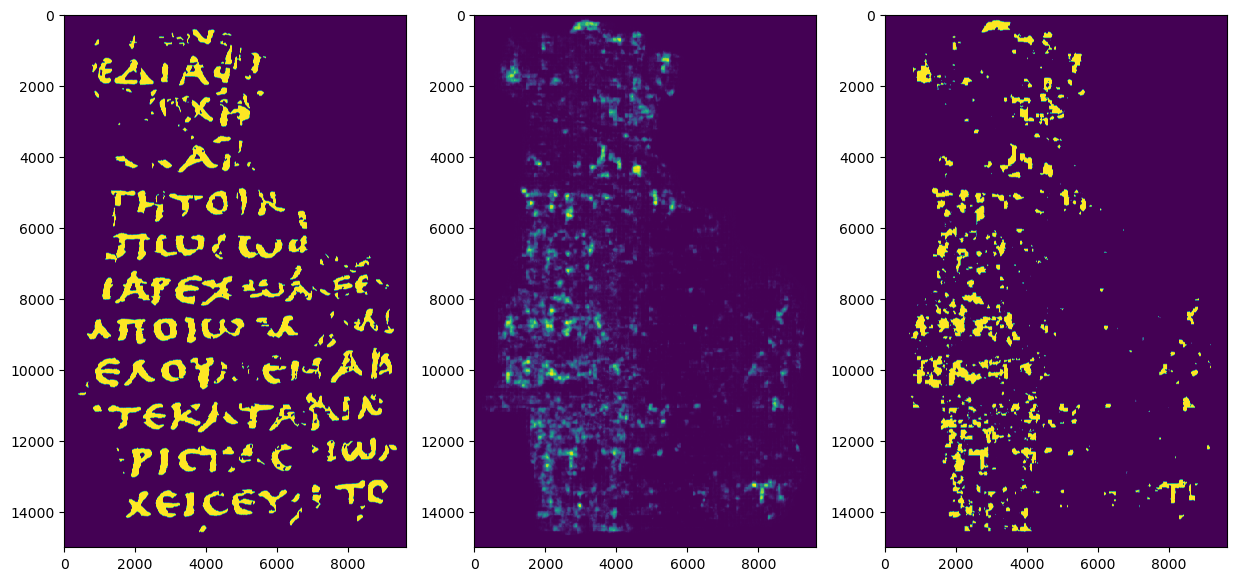

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([1.22327387e+08, 7.49258900e+06, 4.09223300e+06, 2.66332300e+06,
        1.83681900e+06, 1.29750000e+06, 9.66988000e+05, 7.87863000e+05,
        6.47052000e+05, 5.18645000e+05, 4.11467000e+05, 3.49816000e+05,
        2.63218000e+05, 2.14440000e+05, 1.97447000e+05, 1.70808000e+05,
        1.20682000e+05, 8.75010000e+04, 7.52270000e+04, 3.60510000e+04]),
 array([8.62075456e-06, 4.91052382e-02, 9.82018557e-02, 1.47298473e-01,
        1.96395091e-01, 2.45491708e-01, 2.94588325e-01, 3.43684943e-01,
        3.92781560e-01, 4.41878178e-01, 4.90974795e-01, 5.40071413e-01,
        5.89168030e-01, 6.38264648e-01, 6.87361265e-01, 7.36457883e-01,
        7.85554500e-01, 8.34651117e-01, 8.83747735e-01, 9.32844352e-01,
        9.81940970e-01]),
 <BarContainer object of 20 artists>)

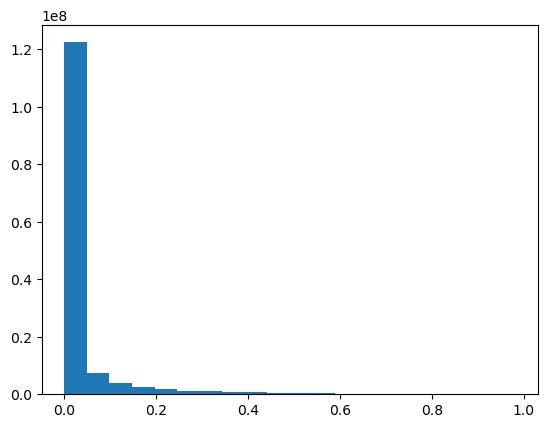

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000